# Setup and utils

In [1]:
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
import json
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from types import SimpleNamespace
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
from scipy.interpolate import griddata

# ------------------------------------ MODEL UTILS ----------------------------------------------
class CustomCNN(nn.Module):
    def __init__(self, input_dim, output_dim, depth, num_channels, hidden_dim_lin, activation_function, kernel_size, use_pooling=True):
        super(CustomCNN, self).__init__()

        # Initial number of input channels, assuming grayscale images
        in_channels = 1

        # Dynamically add convolutional and activation layers based on the specified depth
        for i in range(depth):
            # Create a convolutional layer and add it to the model
            setattr(self, f"conv{i}", nn.Conv2d(in_channels, num_channels, kernel_size=kernel_size, padding=1))

            # Create an activation layer (e.g., ReLU) and add it to the model
            setattr(self, f"act{i}", activation_function())

            # Update the input dimensions after convolution
            input_dim = (input_dim - kernel_size + 2 * 1) + 1

            # Optionally add pooling layers to reduce spatial dimensions
            if use_pooling and (i+1) % depth == 0:
                setattr(self, f"pool{i}", nn.MaxPool2d(2))
                input_dim = input_dim // 2

            # Update the input channels for the next convolutional layer
            in_channels = num_channels

        # Compute the size of the flattened features for the fully connected layer
        flattened_size = in_channels * input_dim * input_dim

        # Add two fully connected layers for classification
        self.fc_1 = nn.Linear(flattened_size, hidden_dim_lin)
        self.relu = activation_function()
        self.fc_2 = nn.Linear(hidden_dim_lin, output_dim)

        # Add log softmax layer for multi-class classification output
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
      # Iterate over each module in the CustomCNN class
      for layer_name, layer in self.named_children():
          # Process the input tensor through convolutional and activation layers
          if "conv" in layer_name or "act" in layer_name:
              x = layer(x)
          # Process the input tensor through pooling layers if they exist
          elif "pool" in layer_name:
              x = layer(x)
          # If reached fully connected layers, break the loop
          elif isinstance(layer, nn.Linear):
              break

      # Flatten the tensor to fit the input shape of the fully connected layers
      x = x.view(x.size(0), -1)

      # Pass the tensor through the fully connected layers
      x = self.fc_1(x)
      x = self.relu(x)
      x = self.fc_2(x)

      # Return log softmax activated output
      return self.logsoftmax(x)

def generate_cnn(input_dim, output_dim, depth, num_channels, hidden_dim_lin, kernel_size, activation_function=nn.ReLU, use_pooling=True):
    model = CustomCNN(input_dim, output_dim, depth, num_channels, hidden_dim_lin, activation_function, kernel_size, use_pooling)
    return model

class Trainer:
    """
    A class for training and evaluating a model with early stopping and best model saving functionalities.

    Attributes:
    - model: PyTorch model to be trained and evaluated.
    - dataloader: Contains data loaders (train, validation, test) for training and evaluation.
    - params: Dictionary containing various hyperparameters and settings.
    - device: the device to which tensors should be moved before computation.
    - optimizer: The optimizer for training.
    - best_model_state: State dictionary of the best model.
    - max_val_acc: The highest validation accuracy encountered during training.
    - no_improve_epochs: Number of epochs without improvement in validation accuracy.
    - is_cnn: Flag indicating if the model is a CNN.
    - is_debug: Flag indicating if debug information should be printed.
    - classification_report_flag: Flag indicating if a classification report should be generated.

    Methods:
    - train_epoch(): Runs a single epoch of training.
    - evaluate(loader): Evaluates the model on a given data loader.
    - save_best_model(): Saves the current state of the model as the best model.
    - save_checkpoint(epoch, train_acc, val_acc): Saves the current state of the model and other information as a checkpoint.
    - early_stopping_check(val_acc): Checks the stopping criterion and performs actions based on it.
    - train(): Runs the training process for a number of epochs, with early stopping functionality.

    Usage:
    params = {
      'device': 'cuda',
      'lr': 0.001,
      'num_train': 10,
      'early_stop_patience': 3,
      'save_best': True,
      'save_checkpoints': False,
      'is_cnn': True,
      'is_debug': True,
      'classification_report_flag': True
    }

    trainer = Trainer(model, dataloader, params)
    train_acc, test_acc, effective_epochs, checkpoints = trainer.train()
    """
    def __init__(self, model, dataloader, params):
        self.model = model
        self.dataloader = dataloader
        self.params = params
        self.device = torch.device(params['device'])
        self.optimizer = optim.Adam(model.parameters(), lr=params['lr'])
        # optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        # Initialize best_model_state with the current model state
        self.best_model_state = copy.deepcopy(self.model.state_dict())
        self.max_val_acc = 0.
        self.no_improve_epochs = 0
        self.is_cnn = params.get('is_cnn', False)
        self.is_debug = params.get('is_debug', False)
        self.classification_report_flag = params.get('classification_report_flag', False)
        self.logger = params.get('logger', print)

    def train_epoch(self):
      self.model.train()
      for batch_idx, (data, target) in enumerate(self.dataloader.train_loader):
          # Print the size of the current batch
          if self.is_cnn:
            data = data.view(data.size(0), 1, 28, 28)
          else:
            data = data.reshape([data.shape[0], -1])
          data, target = data.to(self.device), target.to(self.device)
          self.optimizer.zero_grad()
          output = self.model(data)
          loss = F.nll_loss(output, target)
          loss.backward()
          self.optimizer.step()

          if self.is_debug and batch_idx % 20 == 0:
              self.logger(f"Batch: {batch_idx}, Loss: {loss.item()}")

    def evaluate(self, loader):
        return eval(self.model, self.device, loader, self.is_debug, self.classification_report_flag, self.is_cnn)

    def save_best_model(self):
        torch.save(self.model.state_dict(), 'best_model.pth')

    def save_checkpoint(self, epoch, train_acc, val_acc):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_acc': train_acc,
            'val_acc': val_acc
        }
        torch.save(checkpoint, f'checkpoint_epoch_{epoch}.pth')
        return checkpoint

    def early_stopping_check(self, val_acc):
        if val_acc > self.max_val_acc:
            self.max_val_acc = val_acc
            self.no_improve_epochs = 0
            # Deep copy the model's state
            self.best_model_state = copy.deepcopy(self.model.state_dict())
            if self.params.get('save_best', False):
                self.save_best_model()
        else:
            self.no_improve_epochs += 1
            if self.no_improve_epochs >= self.params['early_stop_patience']:
                self.logger("Early stopping invoked.")
                # Only load if best_model_state has been set
                if self.best_model_state is not None:
                    self.model.load_state_dict(self.best_model_state)
                return True
        return False

    def train(self, verbose=1):
        effective_epochs = 0
        checkpoints = []

        for epoch in range(self.params['num_train']):
            effective_epochs += 1
            self.train_epoch()

            train_acc = self.evaluate(self.dataloader.train_loader)
            val_acc = self.evaluate(self.dataloader.val_loader)
            if verbose >= 1:
                self.logger(f'Epoch: {epoch} \tTraining Accuracy: {train_acc*100:.2f}%')
                self.logger(f'Validation Accuracy: {val_acc*100:.2f}%')

            if self.params.get('early_stop_patience', None):
                if self.early_stopping_check(val_acc):
                    self.model.load_state_dict(self.best_model_state)
                    break

            if self.params.get('save_checkpoints', False):
                checkpoint = self.save_checkpoint(epoch, train_acc, val_acc)
                checkpoints.append(checkpoint)

        # Final evaluations
        train_acc = self.evaluate(self.dataloader.train_loader)
        test_acc = self.evaluate(self.dataloader.test_loader)

        return train_acc, test_acc, effective_epochs, checkpoints

def eval(model, device, dataset_loader, debug=False, classification_report_flag=False, is_cnn=True, logger=print):
    """
    Evaluates the model on the given dataset loader.

    Parameters:
    - model: the PyTorch model to evaluate.
    - device: the device to which tensors should be moved before computation.
    - dataset_loader: DataLoader for evaluation.
    - debug: whether to print debug info like loss and accuracy.
    - classification_report_flag: whether to print a classification report.
    - is_cnn: a flag indicating if the model is a CNN. If it's not, the input data will be reshaped.
    - logger: logging function for printing messages.

    Returns:
    - Accuracy of the model on the provided dataset loader.

    Usage:
    - accuracy = eval(model, device, dataset_loader, debug=False, is_cnn=False, classification_report_flag=False)
    """

    model.eval()
    test_loss, correct = 0., 0.
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in dataset_loader:
            if is_cnn:
              data = data.view(data.size(0), 1, 28, 28)
            else:
              data = data.reshape([data.shape[0], -1])
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data

    if debug:
        logger('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, num_data, 100. * acc))

    if classification_report_flag:
        unique_labels = np.unique(all_labels).tolist()
        logger(classification_report(all_labels, all_preds, labels=unique_labels, target_names=[f'Class {i}' for i in unique_labels]))

    return acc

def cut_custom_cnn_model(model, cut_point, freeze=True, reinitialize=False):
    """
    Cut the CustomCNN model at a specific layer and reinitialize the weights for layers after cut_point.

    Parameters:
    - model (CustomCNN): Original CustomCNN model.
    - cut_point (int): Layer index (in terms of conv layers) at which to modify the model.
    - freeze (bool): If True, layers before cut_point will have their weights frozen.
    - reinitialize (bool): If True, layers after cut_point will have their weights reinitialized.

    Returns:
    - new_model (CustomCNN): Modified model.
    """

    new_model = copy.deepcopy(model)

    # Get names of layers in the model
    layer_names = list(new_model._modules.keys())

    # Find indices of Conv layers
    conv_indices = [i for i, name in enumerate(layer_names) if 'conv' in name]
    #print(conv_indices)

    # If freeze is True, set requires_grad to False for layers before cut_point
    if freeze:
        for idx in conv_indices[:cut_point]:
            for param in getattr(new_model, layer_names[idx]).parameters():
                param.requires_grad = False

    # Reinitialize layers after cut_point
    if reinitialize:
        for idx in conv_indices[cut_point:]:
            layer = getattr(new_model, layer_names[idx])
            nn.init.kaiming_uniform_(layer.weight, a=0, mode='fan_in', nonlinearity='relu')
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

    # reinit the final dense layer anyway
    new_model.fc_2.reset_parameters()

    # if reinit_both_dense: reinit the one before the last one too
    if params["reinit_both_dense"]:
        new_model.fc_1.reset_parameters()

    return new_model

# --------------------------------- DATA UTILS -----------------------------------
def reduce_dataset(dataloader, percentage, balanced=True, seed=42):

    """
    Reduces the dataset to the given percentage. Can ensure class balance if needed.

    Parameters:
    - dataloader: PyTorch DataLoader object.
    - percentage: Desired percentage of the original dataset.
    - balanced: If True, ensures class balance. If False, reduces randomly.
    - seed: Seed for reproducibility.

    Returns:
    - reduced_dataloader: DataLoader with the reduced dataset.
    """
    # Extract the dataset from the dataloader
    dataset = dataloader.dataset

    # Extract all data and labels from the dataset
    X = [dataset[i][0] for i in range(len(dataset))]
    y = [dataset[i][1] for i in range(len(dataset))]

    # Set the seed for reproducibility
    torch.manual_seed(seed)

    if not balanced:
        # Determine the number of samples to keep
        num_samples = int(len(dataset) * percentage)

        # Randomly select indices without replacement
        indices = torch.randperm(len(dataset))[:num_samples].tolist()

    else:
        # Get unique classes and their counts
        classes, class_counts = torch.unique(torch.tensor(y), return_counts=True)

        # Determine the number of samples per class to keep
        num_samples_per_class = int(len(dataset) * percentage / len(classes))
        indices = []

        for class_label in classes:
            class_indices = [i for i, label in enumerate(y) if label == class_label]

            # Randomly select indices without replacement for each class
            class_selected_indices = torch.randperm(len(class_indices))[:num_samples_per_class].tolist()
            indices.extend([class_indices[i] for i in class_selected_indices])

    # Use a Subset of the original dataset to create a reduced dataset
    reduced_dataset = data.Subset(dataset, indices)

    # Create a DataLoader with the reduced dataset.
    reduced_dataloader = data.DataLoader(reduced_dataset, batch_size=dataloader.batch_size, shuffle=True)

    return reduced_dataloader

class RelabeledSubset(torch.utils.data.Dataset):
    def __init__(self, dataset, offset):
        self.dataset = dataset
        self.offset = offset

    def __getitem__(self, idx):
        data, label = self.dataset[idx]
        # Offset the label to start from 0
        label = label - self.offset
        return data, label

    def __len__(self):
        return len(self.dataset)

class TransferLearningMNIST(object):
    def __init__(self, batch_size, input_dim=28*28, val_split=0.1, num_workers=0):
        self.input_dim = input_dim
        self.output_dim = 10
        self.val_split = val_split

        def filter_dataset(dataset, classes):
            indices = [i for i, t in enumerate(dataset.targets) if t in classes]
            return torch.utils.data.Subset(dataset, indices)

        mnist_train_data = datasets.MNIST(
            '../data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        pretrain_train_data = filter_dataset(mnist_train_data, list(range(5)))
        finetune_train_data = filter_dataset(mnist_train_data, list(range(5, 10)))

        pretrain_len = len(pretrain_train_data)
        finetune_len = len(finetune_train_data)
        pretrain_val_len = int(val_split * pretrain_len)
        finetune_val_len = int(val_split * finetune_len)
        SEED = 42
        pretrain_train_set, pretrain_val_set = torch.utils.data.random_split(
            pretrain_train_data, [pretrain_len - pretrain_val_len, pretrain_val_len], generator=torch.Generator().manual_seed(SEED))
        finetune_train_set, finetune_val_set = torch.utils.data.random_split(
            finetune_train_data, [finetune_len - finetune_val_len, finetune_val_len], generator=torch.Generator().manual_seed(SEED))

        self.pretrain_train_loader = torch.utils.data.DataLoader(pretrain_train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        self.pretrain_val_loader = torch.utils.data.DataLoader(pretrain_val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        # Use the RelabeledSubset for fine-tuning datasets
        finetune_train_set = RelabeledSubset(finetune_train_set, 5)
        finetune_val_set = RelabeledSubset(finetune_val_set, 5)

        self.finetune_train_loader = torch.utils.data.DataLoader(finetune_train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        self.finetune_val_loader = torch.utils.data.DataLoader(finetune_val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        mnist_test_data = datasets.MNIST(
            '../data',
            train=False,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        pretrain_test_data = filter_dataset(mnist_test_data, list(range(5)))
        finetune_test_data = filter_dataset(mnist_test_data, list(range(5, 10)))

        self.pretrain_test_loader = torch.utils.data.DataLoader(pretrain_test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        # Use the RelabeledSubset for fine-tuning test datasets
        finetune_test_data = RelabeledSubset(finetune_test_data, 5)
        self.finetune_test_loader = torch.utils.data.DataLoader(finetune_test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        # Complete test loader contains all test examples.
        self.complete_test_loader = torch.utils.data.DataLoader(mnist_test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

class TransferLearningMNISTWrapper:
    """
    This wrapper class provides a convenient way to switch between pretraining and fine-tuning phases.

    It allows for changing the phase and accordingly updating the data loaders (train, val, test)
    to either pretraining or fine-tuning sets.
    """
    def __init__(self, transferLearningMNISTObj, phase):
        """
        Initializes the TransferLearningMNISTWrapper object.

        Parameters:
        - transferLearningMNISTObj: An instance of the TransferLearningMNIST class.
        - phase: String indicating the current phase ("pretrain" or "finetune").
        """
        self.transferLearningMNISTObj = transferLearningMNISTObj
        self.phase = phase
        self.input_dim = self.transferLearningMNISTObj.input_dim
        self.output_dim = self.transferLearningMNISTObj.output_dim
        self.update_phase(phase)

    def update_phase(self, phase):
        """
        Updates the phase and the corresponding data loaders.

        Parameters:
        - phase: String indicating the desired phase ("pretrain" or "finetune").

        Throws:
        - ValueError: If the phase is neither "pretrain" nor "finetune".
        """
        self.phase = phase
        if phase == 'pretrain':
            self.train_loader = self.transferLearningMNISTObj.pretrain_train_loader
            self.val_loader = self.transferLearningMNISTObj.pretrain_val_loader
            self.test_loader = self.transferLearningMNISTObj.pretrain_test_loader
        elif phase == 'finetune':
            self.train_loader = self.transferLearningMNISTObj.finetune_train_loader
            self.val_loader = self.transferLearningMNISTObj.finetune_val_loader
            self.test_loader = self.transferLearningMNISTObj.finetune_test_loader
        else:
            raise ValueError('Phase must be either "pretrain" or "finetune".')

    def get_current_phase(self):
      return self.phase

# ------------------------------------------ PLOTTING UTILS -------------------------------------------
'''def effective_rank(singular_values):
    sigma_max = np.max(singular_values)
    sigma_min = singular_values[-1] if singular_values[-1] > 0 else np.min(singular_values[singular_values > 0])
    # print(sigma_max, sigma_min)
    print(np.sqrt(sigma_max / sigma_min))
    print('----')
    return np.sqrt(sigma_max / sigma_min)'''

def effective_rank(singular_values):
    normalized_singular_values = singular_values / np.sum(singular_values)
    entropy = -np.sum(normalized_singular_values * np.log(normalized_singular_values))
    eff_rank = np.exp(entropy)
    return eff_rank

def plot_layer_effective_ranks(model, print_ranks=True):
    effective_ranks = []
    layer_names = []

    for name, param in model.named_parameters():
        if 'weight' in name:  # We are only interested in weight matrices
            weight_matrix = param.detach().cpu().numpy()
            singular_values = np.linalg.svd(weight_matrix, compute_uv=False)
            eff_rank = effective_rank(singular_values)
            effective_ranks.append(eff_rank)
            layer_names.append(name)

    if print_ranks:
        for layer_name, eff_rank in zip(layer_names, effective_ranks):
            print(f'{layer_name}: {eff_rank:.4f}')

    # Plotting
    plt.figure(figsize=(15, 5))
    plt.bar(layer_names, effective_ranks, color='green')
    plt.xlabel('Layer')
    plt.ylabel('Effective Rank')
    plt.title('Effective Rank of Weight Matrices for Each Layer')
    plt.grid(True)

    y_max = np.max(effective_ranks) + 1  # Get maximum rank and add 1 for better visualization
    y_min = np.min(effective_ranks) - 1  # Get minimum rank and subtract 1 for better visualization
    plt.yticks(np.arange(0, int(y_max)+2, step=2))  # Set yticks

    plt.show()

#EXPERIMENT SETUP 1: _FREEZE, REINIT, POOLING, DENSE:REINIT BOTH_
- percentages_set_1 = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1]
- dataset: same as before MNIST 5 to 5

- architecture:
  - Conv 1 (5,5), channels=10
  - Relu
  - Conv 2 (5,5), channels=10
  - Relu
  - Conv 3 (5,5), channels=10
  - Relu
  - _POOLING_
  - Dense 1 (x, a) x=output shape of prev layer, a:random hidden layer width (we use 128)
  - Relu
  - Dense 2 (a, 5)
  - softmax

- lr pretraining = 0.001
- lr finetuning = 0.0001
- lr end-to-end = 0.001

- Freezing the layers before the cut: _YES_
- Reinitializing the Convolutional layers after the cut: _YES_
- Reinitializing Dense 1: _YES_
- Reinitializing Dense 2: _YES_


In [2]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps")
device

device(type='mps')

In [3]:
percentages = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1]

# cuts=0 means: end-to-end model if we are reinitializing
cuts = [0,1,2,3]
seed_set = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # currently not being used
repeats = 3
batch_size = 4096

## Pretraining



In [4]:
dataloader = TransferLearningMNIST(batch_size)
dataloader_wrapped = TransferLearningMNISTWrapper(dataloader, phase = 'pretrain')

# Changes Here for the experiments
params = {
      'depth': 3,
      'width': 10, # num channels for CNN
      'hidden_dim_lin': 128,
      'activation_function': nn.ReLU,
      'kernel_size': 5,
      'device': device,
      'lr': 0.001,
      'num_train': 20,
      'early_stop_patience': 6,
      'save_best': True,
      'save_checkpoints': True,
      'is_cnn': True,
      'is_debug': False,
      'classification_report_flag': False,
      'use_pooling': False,   # CHANGE
      'freeze': True,         # CHANGE: freeze the conv layers before the cut
      'reinit': False,         # CHANGE: reinit the conv lyers only after the cut
      'reinit_both_dense': True   # CHANGE: True for reinitialize both dense layers, False for reinit only the last dense layer
    }

# Create DNN model
pretrained_model = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
                     hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=params['use_pooling'])
pretrained_model.to(device)

CustomCNN(
  (conv0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (fc_1): Linear(in_features=4840, out_features=128, bias=True)
  (relu): ReLU()
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

In [5]:
# Train and evaluate
trainer = Trainer(pretrained_model, dataloader_wrapped, params)
train_acc, test_acc, effective_epochs, checkpoints = trainer.train()

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")

Epoch: 0 	Training Accuracy: 58.87%
Validation Accuracy: 56.78%
Epoch: 1 	Training Accuracy: 90.26%
Validation Accuracy: 89.83%
Epoch: 2 	Training Accuracy: 92.06%
Validation Accuracy: 91.14%
Epoch: 3 	Training Accuracy: 94.15%
Validation Accuracy: 93.36%
Epoch: 4 	Training Accuracy: 95.39%
Validation Accuracy: 94.61%
Epoch: 5 	Training Accuracy: 96.00%
Validation Accuracy: 95.29%
Epoch: 6 	Training Accuracy: 96.50%
Validation Accuracy: 95.39%
Epoch: 7 	Training Accuracy: 96.82%
Validation Accuracy: 95.75%
Epoch: 8 	Training Accuracy: 97.01%
Validation Accuracy: 96.01%
Epoch: 9 	Training Accuracy: 97.23%
Validation Accuracy: 96.31%
Epoch: 10 	Training Accuracy: 97.36%
Validation Accuracy: 96.50%
Epoch: 11 	Training Accuracy: 97.49%
Validation Accuracy: 96.57%
Epoch: 12 	Training Accuracy: 97.68%
Validation Accuracy: 97.03%
Epoch: 13 	Training Accuracy: 97.74%
Validation Accuracy: 97.06%
Epoch: 14 	Training Accuracy: 97.74%
Validation Accuracy: 97.22%
Epoch: 15 	Training Accuracy: 98.01

conv0.weight: 40.0839
conv1.weight: 383.9444
conv2.weight: 386.2754
fc_1.weight: 107.9966
fc_2.weight: 9.8957


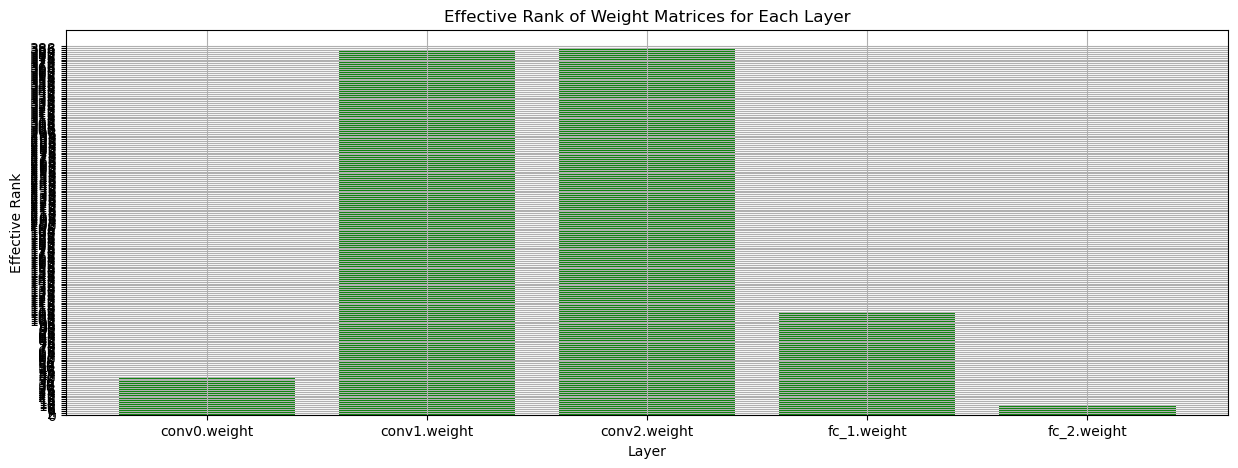

In [8]:
# Effective Rank of Pretrained model
plot_layer_effective_ranks(pretrained_model)  # Note: You'll need to define or load 'model' before calling this function


## Fine-tuning Experiments

In [10]:
params["lr"] = 0.0001
dataloader_wrapped.update_phase('finetune')

# Store results
results = []
# Store unique combinations that have been tested
tested_combinations = set()

for sampled_percentage in percentages:
    for sampled_cut_point in cuts:
        for repeat in range(repeats):
            # Add the combination to the tested set
            tested_combinations.add((sampled_percentage, sampled_cut_point))

            # Print or log the sampled values for transparency
            print(f"\nSampled Percentage: {sampled_percentage}, Sampled Cut Point: {sampled_cut_point}, Repeat: {repeat}")

            # Reduce the dataset
            train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed=random.randint(0, 100))
            dataset_namespace_new = SimpleNamespace(train_loader=train_loader_reduced, test_loader=dataloader_wrapped.test_loader, val_loader=dataloader_wrapped.val_loader)

            # Copy and then cut the model - we already deepcopy it in the function: pretrained_model
            model_new = cut_custom_cnn_model(pretrained_model, cut_point=sampled_cut_point, freeze=params["freeze"], reinitialize=params["reinit"])

            # Train and evaluate
            trainer = Trainer(model_new, dataset_namespace_new, params)
            train_acc, test_acc, effective_epochs, checkpoints = trainer.train(verbose=0)
            print(f"Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

            # Store the results
            results.append((sampled_percentage, sampled_cut_point, repeat, train_acc, test_acc))


Sampled Percentage: 0.001, Sampled Cut Point: 0, Repeat: 0
Training Accuracy: 1.0000, Test Accuracy: 0.7727

Sampled Percentage: 0.001, Sampled Cut Point: 0, Repeat: 1
Early stopping invoked.
Training Accuracy: 0.9600, Test Accuracy: 0.7817

Sampled Percentage: 0.001, Sampled Cut Point: 0, Repeat: 2
Training Accuracy: 0.9600, Test Accuracy: 0.8157

Sampled Percentage: 0.001, Sampled Cut Point: 1, Repeat: 0
Training Accuracy: 0.9600, Test Accuracy: 0.8023

Sampled Percentage: 0.001, Sampled Cut Point: 1, Repeat: 1
Training Accuracy: 0.9600, Test Accuracy: 0.8097

Sampled Percentage: 0.001, Sampled Cut Point: 1, Repeat: 2
Training Accuracy: 0.9600, Test Accuracy: 0.8070

Sampled Percentage: 0.001, Sampled Cut Point: 2, Repeat: 0
Training Accuracy: 1.0000, Test Accuracy: 0.8397

Sampled Percentage: 0.001, Sampled Cut Point: 2, Repeat: 1
Training Accuracy: 0.9600, Test Accuracy: 0.8107

Sampled Percentage: 0.001, Sampled Cut Point: 2, Repeat: 2
Training Accuracy: 1.0000, Test Accuracy: 0.

In [27]:
#training of baseline, end to end, models (#trials x #percentages)

params["lr"] = 0.001 #back to training learning rate 
dataloader_wrapped.update_phase('finetune')


for sampled_percentage in percentages:
        for repeat in range(repeats):

            # Print or log the sampled values for transparency
            print(f"\nSampled Percentage: {sampled_percentage}, Sampled Cut Point: {-1}, Repeat: {repeat}")

            # Reduce the dataset
            train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed=random.randint(0, 100))
            dataset_namespace_new = SimpleNamespace(train_loader=train_loader_reduced, test_loader=dataloader_wrapped.test_loader, val_loader=dataloader_wrapped.val_loader)

            # Copy and then cut the model - we already deepcopy it in the function: pretrained_model
            model_temp = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
                     hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=params['use_pooling'])
            model_temp.to(device)

            # Train and evaluate
            trainer = Trainer(model_temp, dataset_namespace_new, params)
            train_acc, test_acc, effective_epochs, checkpoints = trainer.train(verbose=0)
            print(f"Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

            # Store the results
            results.append((sampled_percentage, -1, repeat, train_acc, test_acc)) # -1 for the cut point means it's baseline


Sampled Percentage: 0.001, Sampled Cut Point: 3, Repeat: 0
Training Accuracy: 1.0000, Test Accuracy: 0.7638

Sampled Percentage: 0.001, Sampled Cut Point: 3, Repeat: 1
Training Accuracy: 0.9200, Test Accuracy: 0.6353

Sampled Percentage: 0.001, Sampled Cut Point: 3, Repeat: 2
Training Accuracy: 1.0000, Test Accuracy: 0.7673

Sampled Percentage: 0.002, Sampled Cut Point: 3, Repeat: 0
Training Accuracy: 0.9200, Test Accuracy: 0.8375

Sampled Percentage: 0.002, Sampled Cut Point: 3, Repeat: 1
Training Accuracy: 0.9200, Test Accuracy: 0.8167

Sampled Percentage: 0.002, Sampled Cut Point: 3, Repeat: 2
Training Accuracy: 0.8600, Test Accuracy: 0.7803

Sampled Percentage: 0.005, Sampled Cut Point: 3, Repeat: 0
Training Accuracy: 0.8769, Test Accuracy: 0.8383

Sampled Percentage: 0.005, Sampled Cut Point: 3, Repeat: 1
Training Accuracy: 0.9385, Test Accuracy: 0.8410

Sampled Percentage: 0.005, Sampled Cut Point: 3, Repeat: 2
Training Accuracy: 0.9077, Test Accuracy: 0.8570

Sampled Percentage

### Print the results and save somewhere for future analysis

In [28]:
print(results)

[(0.001, 0, 0, 1.0, 0.7726805184118494), (0.001, 0, 1, 0.96, 0.7817321538778029), (0.001, 0, 2, 0.96, 0.8156757868751285), (0.001, 1, 0, 0.96, 0.8023040526640609), (0.001, 1, 1, 0.96, 0.8097099362271137), (0.001, 1, 2, 0.96, 0.8070355893849003), (0.001, 2, 0, 1.0, 0.8397449084550505), (0.001, 2, 1, 0.96, 0.8107385311664267), (0.001, 2, 2, 1.0, 0.8025097716519235), (0.001, 3, 0, 1.0, 0.7080847562229994), (0.001, 3, 1, 0.96, 0.8300761160255091), (0.001, 3, 2, 1.0, 0.8337790578070355), (0.002, 0, 0, 0.98, 0.8401563464307755), (0.002, 0, 1, 0.96, 0.868339847767949), (0.002, 0, 2, 0.98, 0.8401563464307755), (0.002, 1, 0, 0.94, 0.8467393540423781), (0.002, 1, 1, 0.92, 0.8778029212096277), (0.002, 1, 2, 1.0, 0.8594939312898581), (0.002, 2, 0, 0.94, 0.8549681135568813), (0.002, 2, 1, 0.9, 0.8280189261468833), (0.002, 2, 2, 0.9, 0.8516766097510801), (0.002, 3, 0, 0.92, 0.8500308578481793), (0.002, 3, 1, 0.92, 0.8500308578481793), (0.002, 3, 2, 0.96, 0.8839744908455051), (0.005, 0, 0, 0.95384615

## Visualizations

### The Results Table and 3D plot (both go into the report)

In [30]:
# first of all convert results to df and calculate the mean and std of repats
repeats_mean = []
i = 0
for sampled_percentage in percentages:
    for sampled_cut_point in cuts:
        train, test = [], []
        for repeat in range(repeats):
            train.append(results[i][3])
            test.append(results[i][4])
            i += 1
        repeats_mean.append((sampled_percentage, sampled_cut_point, np.mean(train), np.std(train), np.mean(test), np.std(test)))
df = pd.DataFrame(repeats_mean, columns=['Percentage', 'Cut Point', 'Mean Train Accuracy', 'Std Train Accuracy', 'Mean Test Accuracy', 'Std Test Accuracy'])
df

,Percentage,Cut Point,Mean Train Accuracy,Std Train Accuracy,Mean Test Accuracy,Std Test Accuracy
0,0.001,0,0.973333,0.018856,0.790029,0.018507
1,0.001,1,0.960000,0.000000,0.806350,0.003062
2,0.001,2,0.986667,0.018856,0.817664,0.015971
3,0.001,3,0.986667,0.018856,0.790647,0.058400
4,0.002,0,0.973333,0.009428,0.849551,0.013286
5,0.002,1,0.953333,0.033993,0.861345,0.012749
6,0.002,2,0.913333,0.018856,0.844888,0.012004
7,0.002,3,0.933333,0.018856,0.861345,0.016001
8,0.005,0,0.912821,0.029010,0.876637,0.014789
9,0.005,1,0.928205,0.009594,0.886443,0.005309


In [14]:
# Create a 3D scatter plot
fig = px.scatter_3d(df,
                    x='Percentage',
                    y='Cut Point',
                    z='Mean Test Accuracy',  # or 'Train Accuracy' if you want to visualize training accuracy
                    color='Mean Test Accuracy',  # color scale based on test accuracy
                    size_max=18,
                    opacity=0.7)

# Set axis labels
fig.update_layout(scene=dict(xaxis_title='Percentage',
                             yaxis_title='Cut Point',
                             zaxis_title='Test Accuracy'))

fig.show()

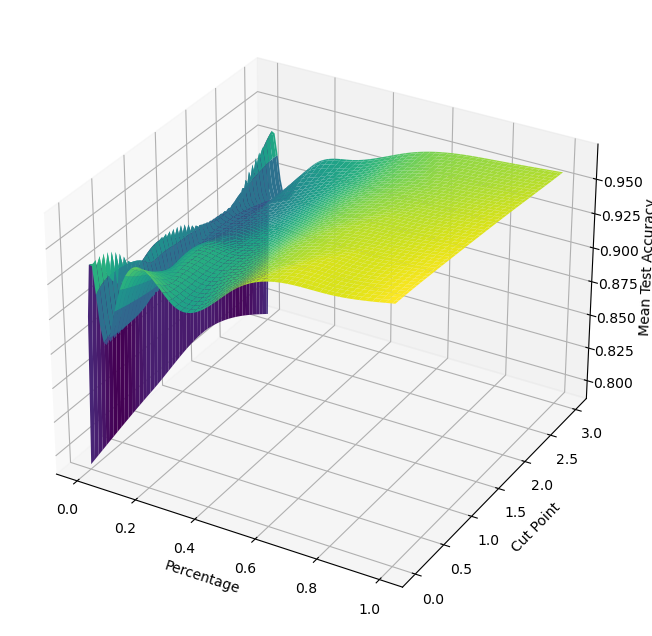

In [15]:
# Create grid values
xi = np.linspace(df['Percentage'].min(), df['Percentage'].max(), 100)
yi = np.linspace(df['Cut Point'].min(), df['Cut Point'].max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate
zi = griddata((df['Percentage'], df['Cut Point']), df['Mean Test Accuracy'], (xi, yi), method='cubic')

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xi, yi, zi, cmap='viridis')
ax.set_xlabel('Percentage')
ax.set_ylabel('Cut Point')
ax.set_zlabel('Mean Test Accuracy')
plt.show()

In [31]:
import pandas as pd

# Data provided by the user
data_tuples = results

# Define column names
columns = ['Percentage', 'Cut Point', 'Trial', 'Train Accuracy', 'Test Accuracy']

# Create DataFrame
df = pd.DataFrame(data_tuples, columns=columns)

# Calculate mean and standard deviation for test accuracies
# Assuming that the provided data has a pattern where every three tuples belong to the same
# percentage and cut point but different trials
df['Mean Train Accuracy'] = df.groupby(['Percentage', 'Cut Point'])['Train Accuracy'].transform('mean')
df['Mean Test Accuracy'] = df.groupby(['Percentage', 'Cut Point'])['Test Accuracy'].transform('mean')

# Now we display the DataFrame, though for brevity I'm only showing the first few rows here.
df.head()


,Percentage,Cut Point,Trial,Train Accuracy,Test Accuracy,Mean Train Accuracy,Mean Test Accuracy
0,0.001,0,0,1.00,0.772681,0.973333,0.790029
1,0.001,0,1,0.96,0.781732,0.973333,0.790029
2,0.001,0,2,0.96,0.815676,0.973333,0.790029
3,0.001,1,0,0.96,0.802304,0.960000,0.806350
4,0.001,1,1,0.96,0.809710,0.960000,0.806350


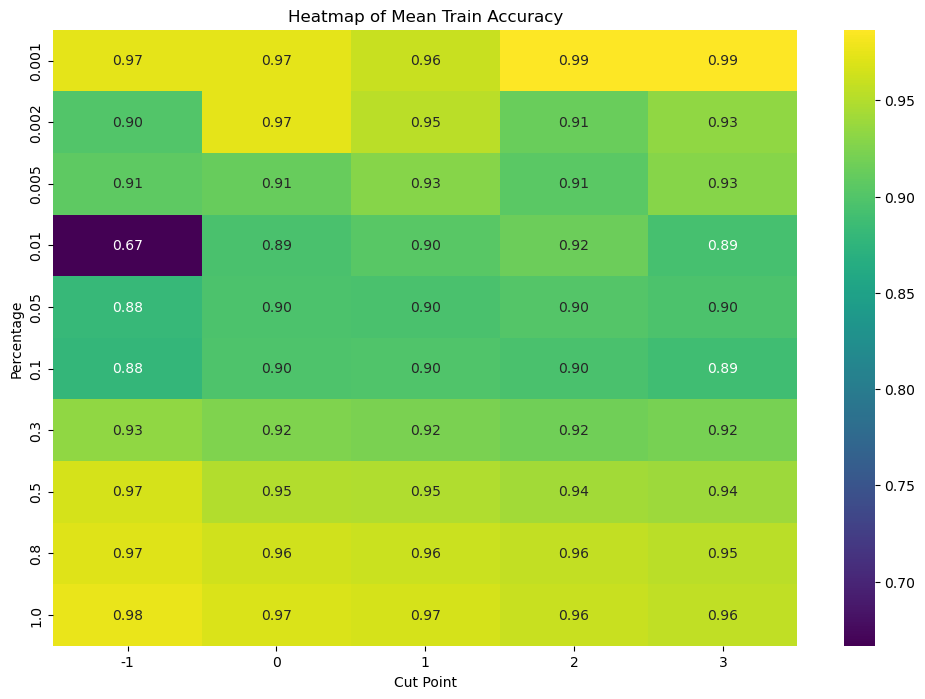

In [32]:
# For the heatmap, we will use the mean test accuracy, aggregated over trials for each combination of 'Percentage' and 'Cut Point'

# We will pivot the dataframe to get the mean test accuracy for each combination of 'Percentage' and 'Cut Point'
heatmap_data = df.pivot_table(index='Percentage', columns='Cut Point', values='Mean Train Accuracy', aggfunc='mean')

# Generating the heatmap using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f")
plt.title('Heatmap of Mean Train Accuracy')
plt.xlabel('Cut Point')
plt.ylabel('Percentage')
plt.show()


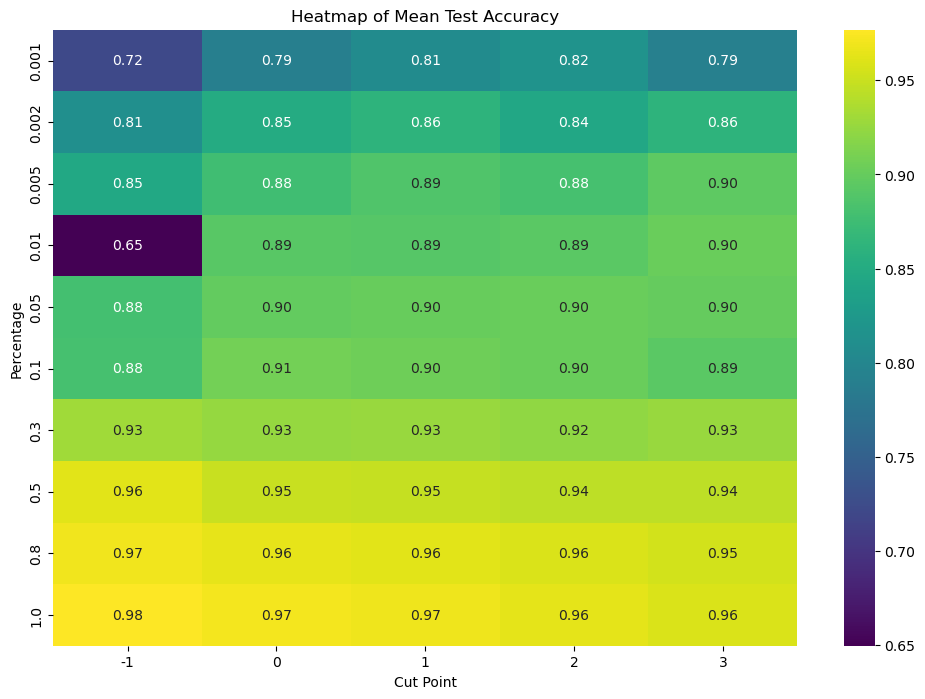

In [35]:
# For the heatmap, we will use the mean test accuracy, aggregated over trials for each combination of 'Percentage' and 'Cut Point'

# We will pivot the dataframe to get the mean test accuracy for each combination of 'Percentage' and 'Cut Point'
heatmap_data = df.pivot_table(index='Percentage', columns='Cut Point', values='Mean Test Accuracy', aggfunc='mean')

# Generating the heatmap using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f")
plt.title('Heatmap of Mean Test Accuracy')
plt.xlabel('Cut Point')
plt.ylabel('Percentage')
plt.show()


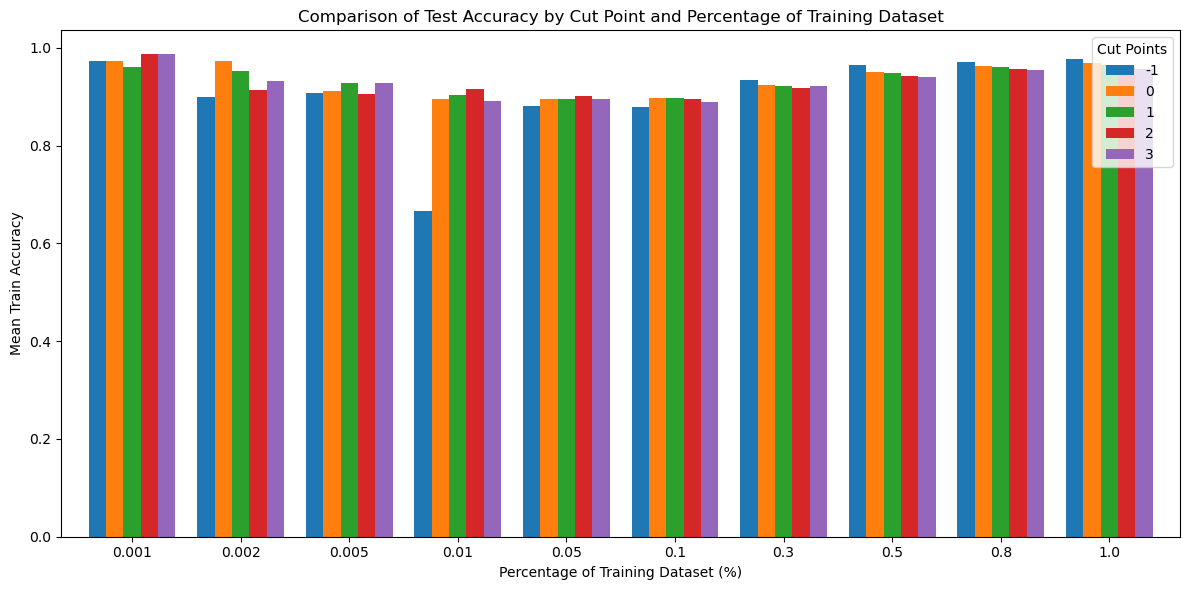

In [36]:
# Create a bar graph for comparing the test accuracies of different cut points at each percentage level.

# Find the mean test accuracy for each cut point at each percentage level.
mean_accuracies = df.groupby(['Cut Point', 'Percentage']).mean()['Mean Train Accuracy'].unstack(0)

# Plotting
mean_accuracies.plot(kind='bar', figsize=(12, 6), width=0.8)

plt.title('Comparison of Test Accuracy by Cut Point and Percentage of Training Dataset')
plt.xlabel('Percentage of Training Dataset (%)')
plt.ylabel('Mean Train Accuracy')
plt.xticks(rotation=0)  # Rotate x-axis labels to show them horizontally.
plt.legend(title='Cut Points')
plt.tight_layout()
plt.show()


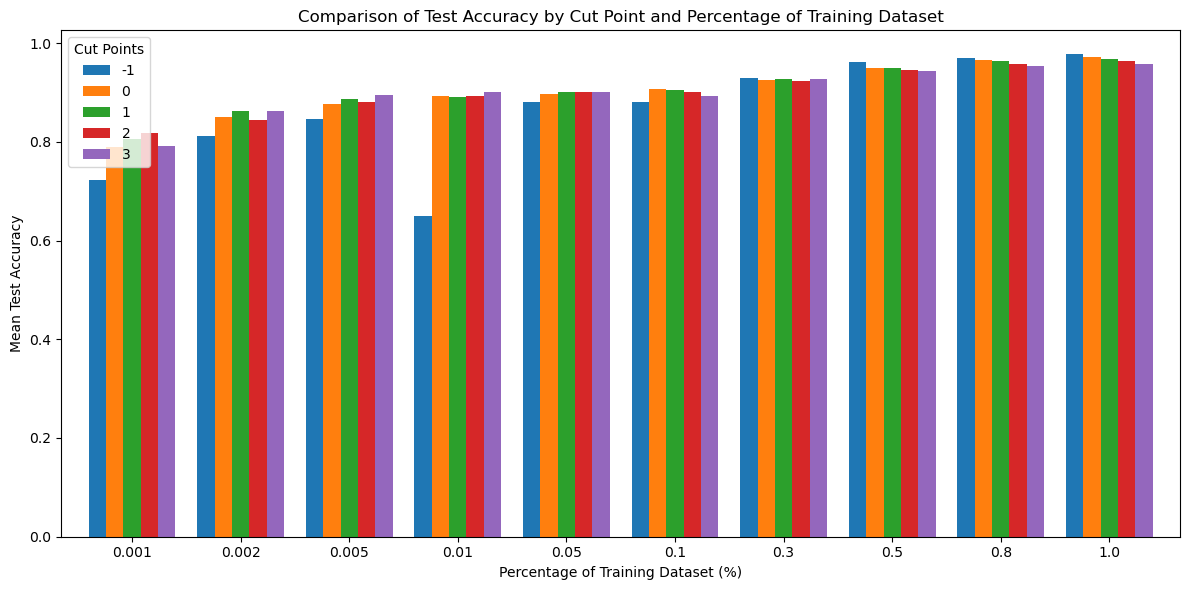

In [37]:
# Create a bar graph for comparing the test accuracies of different cut points at each percentage level.

# Find the mean test accuracy for each cut point at each percentage level.
mean_accuracies = df.groupby(['Cut Point', 'Percentage']).mean()['Mean Test Accuracy'].unstack(0)

# Plotting
mean_accuracies.plot(kind='bar', figsize=(12, 6), width=0.8)

plt.title('Comparison of Test Accuracy by Cut Point and Percentage of Training Dataset')
plt.xlabel('Percentage of Training Dataset (%)')
plt.ylabel('Mean Test Accuracy')
plt.xticks(rotation=0)  # Rotate x-axis labels to show them horizontally.
plt.legend(title='Cut Points')
plt.tight_layout()
plt.show()


-----

In [14]:
dataloader = TransferLearningMNIST(batch_size)
dataloader_wrapped = TransferLearningMNISTWrapper(dataloader, phase = 'pretrain')

device = 'mps' 
# Changes Here for the experiments
params = {
      'depth': 3,
      'width': 3, # num channels for CNN -> 3
      'hidden_dim_lin': 128,
      'activation_function': nn.ReLU,
      'kernel_size': 5,
      'device': device,
      'lr': 0.001,
      'num_train': 20,
      'early_stop_patience': 6,
      'save_best': True,
      'save_checkpoints': True,
      'is_cnn': True,
      'is_debug': False,
      'classification_report_flag': False,
      'use_pooling': True,   # CHANGE
      'freeze': True,         # CHANGE: freeze the conv layers before the cut
      'reinit': False,         # CHANGE: reinit the conv lyers only after the cut
      'reinit_both_dense': True   # CHANGE: True for reinitialize both dense layers, False for reinit only the last dense layer
    }

# Create DNN model
pretrained_model = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
                     hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=params['use_pooling'])
pretrained_model.to(device)

# Train and evaluate
trainer = Trainer(pretrained_model, dataloader_wrapped, params)
train_acc, test_acc, effective_epochs, checkpoints = trainer.train()

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")

Epoch: 0 	Training Accuracy: 20.04%
Validation Accuracy: 20.04%
Epoch: 1 	Training Accuracy: 20.04%
Validation Accuracy: 20.04%
Epoch: 2 	Training Accuracy: 22.05%
Validation Accuracy: 21.90%
Epoch: 3 	Training Accuracy: 41.37%
Validation Accuracy: 39.42%
Epoch: 4 	Training Accuracy: 81.14%
Validation Accuracy: 81.24%
Epoch: 5 	Training Accuracy: 89.80%
Validation Accuracy: 89.74%
Epoch: 6 	Training Accuracy: 92.62%
Validation Accuracy: 92.64%
Epoch: 7 	Training Accuracy: 93.66%
Validation Accuracy: 93.49%
Epoch: 8 	Training Accuracy: 94.55%
Validation Accuracy: 94.28%
Epoch: 9 	Training Accuracy: 95.33%
Validation Accuracy: 94.77%
Epoch: 10 	Training Accuracy: 95.66%
Validation Accuracy: 95.13%
Epoch: 11 	Training Accuracy: 96.04%
Validation Accuracy: 95.19%
Epoch: 12 	Training Accuracy: 96.26%
Validation Accuracy: 95.23%
Epoch: 13 	Training Accuracy: 96.49%
Validation Accuracy: 95.72%
Epoch: 14 	Training Accuracy: 96.50%
Validation Accuracy: 95.59%
Epoch: 15 	Training Accuracy: 96.61

In [15]:
print(pretrained_model)

CustomCNN(
  (conv0): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=363, out_features=128, bias=True)
  (relu): ReLU()
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Function to freeze layers of the CNN model
def freeze_cnn_layers(model, freeze_until_layer):
    for name, param in model.named_parameters():
        if freeze_until_layer in name:
            break
        param.requires_grad = False

# Class for the bottleneck network
class BottleneckNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BottleneckNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
       # x = F.relu(self.fc1(x))
        x = self.fc1(x)
        x = self.fc2(x)
        return self.logsoftmax(x)

# Function to perform a forward pass up to a specific layer of the CNN
def forward_cnn_up_to_layer(cnn_model, x, target_layer):
    for layer_name, layer in cnn_model.named_children():
        x = layer(x)
        if layer_name == target_layer:
            break
    return x

# Modified training routine for the bottleneck network
def train_bottleneck_network(bottleneck_model, cnn_model, dataloader, optimizer, epochs, device, target_layer):
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(dataloader.train_loader):
            data, target = data.to(device), target.to(device)

            # Forward pass through CNN up to a certain layer
            cnn_output = forward_cnn_up_to_layer(cnn_model, data, target_layer)
            cnn_output = cnn_output.view(cnn_output.size(0), -1)  # Flatten the output

            # Train only the bottleneck network
            optimizer.zero_grad()
            output = bottleneck_model(cnn_output)
            loss = F.nll_loss(output, target)
            print(f'loss: {loss.item()}')
            loss.backward()
            optimizer.step()

# Example usage
# Assuming cnn_model, dataloader, and device are already defined
freeze_until_layer = 'conv2'  # Specify the layer up to which to freeze
freeze_cnn_layers(pretrained_model, freeze_until_layer)

input_dim = 1452  # Set this according to the output size of the target layer
hidden_dim = 2
output_dim = 5  # Number of classes
bottleneck_model = BottleneckNetwork(input_dim, hidden_dim, output_dim).to(device)

optimizer = optim.Adam(bottleneck_model.parameters(), lr=0.00001)
epochs = 50
train_bottleneck_network(bottleneck_model, pretrained_model, dataloader_wrapped, optimizer, epochs, device, freeze_until_layer)


loss: 2.1471519470214844
loss: 2.143536329269409
loss: 2.151109457015991
loss: 2.1250882148742676
loss: 2.1446127891540527
loss: 2.1211373805999756
loss: 2.1128158569335938
loss: 2.109496831893921
loss: 2.1234219074249268
loss: 2.075591802597046
loss: 2.0616660118103027
loss: 2.075869083404541
loss: 2.0610907077789307
loss: 2.0523715019226074
loss: 2.0574533939361572
loss: 2.0371530055999756
loss: 2.041534185409546
loss: 2.0464677810668945
loss: 2.042788505554199
loss: 2.0181119441986084
loss: 2.0185606479644775
loss: 2.0261025428771973
loss: 2.010800838470459
loss: 2.0135371685028076
loss: 2.0014150142669678
loss: 2.0065157413482666
loss: 1.986141324043274
loss: 1.9885640144348145
loss: 1.9835081100463867
loss: 1.979235291481018
loss: 1.9984064102172852
loss: 1.9771190881729126
loss: 1.96726393699646
loss: 1.983465552330017
loss: 1.952803134918213
loss: 1.9640864133834839
loss: 1.95257568359375
loss: 1.9545254707336426
loss: 1.9489662647247314
loss: 1.9540717601776123
loss: 1.95450782

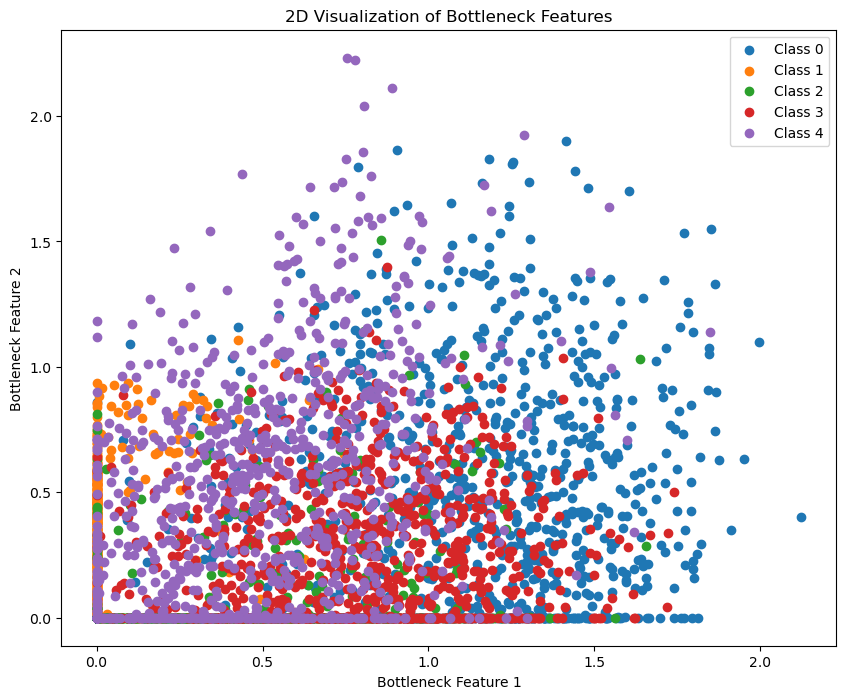

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to get the embeddings from the bottleneck network
def get_embeddings(bottleneck_model, cnn_model, dataloader, device, target_layer):
    bottleneck_model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for data, target in dataloader.test_loader:
            data = data.to(device)
            # Forward pass through CNN up to a certain layer
            cnn_output = forward_cnn_up_to_layer(cnn_model, data, target_layer)
            cnn_output = cnn_output.view(cnn_output.size(0), -1)  # Flatten the output

            # Get the output of the first fully connected layer (hidden layer) in the bottleneck network
            hidden_output = F.relu(bottleneck_model.fc1(cnn_output))
            embeddings.append(hidden_output.cpu().numpy())
            labels.append(target.numpy())

    # Concatenate all batches
    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels, axis=0)
    return embeddings, labels

# Function to plot the embeddings
def plot_embeddings(embeddings, labels, num_classes):
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        idxs = labels == i
        plt.scatter(embeddings[idxs, 0], embeddings[idxs, 1], label=f'Class {i}')
    plt.xlabel('Bottleneck Feature 1')
    plt.ylabel('Bottleneck Feature 2')
    plt.title('2D Visualization of Bottleneck Features')
    plt.legend()
    plt.show()

# Example usage
# Assuming bottleneck_model, cnn_model, dataloader, and device are already defined
embeddings, labels = get_embeddings(bottleneck_model, pretrained_model, dataloader_wrapped, device, freeze_until_layer)
plot_embeddings(embeddings, labels, num_classes=5)  # Adjust num_classes as per your dataset


In [31]:
embeddings

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [12]:
for e in embeddings:
    print(e)

[0.11700551 0.        ]
[0.         0.02546386]
[1.0532352 0.       ]
[1.0083355  0.74564064]
[0. 0.]
[0.6570833 1.2924579]
[1.5692413  0.86974496]
[1.2975799  0.27369952]
[0.         0.10159597]
[0.46393505 0.3555608 ]
[0.4858684  0.48452306]
[0.7115041  0.40722382]
[0.68730927 0.49788758]
[0.8508536  0.68910766]
[1.3174182 0.       ]
[0.04420609 0.84284735]
[1.0252534 0.7022057]
[0.17136332 0.73166144]
[1.2505424 0.2671619]
[1.2158568 1.0860723]
[0.6826187 0.210323 ]
[0.         0.57652164]
[0.34818953 0.05751318]
[0. 0.]
[0.         0.57000774]
[0.10156438 0.13795799]
[0.19621272 0.        ]
[0.7828569 0.3760113]
[0.7442924  0.65237427]
[0. 0.]
[0.5929593  0.71137875]
[0.58341426 0.15420996]
[0.5448416 0.3159859]
[0.8670265 0.       ]
[1.1604873 1.0785011]
[0. 0.]
[0.30911002 0.        ]
[0.10565784 0.42734098]
[0.08397839 0.9160608 ]
[0.75961936 0.        ]
[0.85786927 0.8268742 ]
[1.4208577  0.70440996]
[0.77302605 0.08710807]
[0.        0.3230233]
[0.540739  0.5629848]
[0.       

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNetPlusPlus(nn.Module):
    def __init__(self):
        super(LeNetPlusPlus, self).__init__()
        # MNIST images are 1x28x28 (channels x height x width)
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)  # preserves the size of the image
        self.bn1 = nn.BatchNorm2d(32)
        self.prelu1 = nn.PReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # reduces size by half

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.prelu2 = nn.PReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # reduces size by half

        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.prelu3 = nn.PReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # reduces size by half

        # Define the fully connected layers
        self.fc1 = nn.Linear(128*3*3, 2)  # bottleneck layer, assuming the image size is 3x3 after pooling
        self.fc2 = nn.Linear(2, 10, bias=False)  # no bias is needed before softmax

    def forward(self, x, return_feature=False):
        x = self.maxpool1(self.prelu1(self.bn1(self.conv1(x))))
        x = self.maxpool2(self.prelu2(self.bn2(self.conv2(x))))
        x = self.maxpool3(self.prelu3(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)  # flatten the tensor
        x = self.fc1(x)
        
        # If return_feature is True, return the bottleneck features
        if return_feature:
            return x
        
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)



LeNetPlusPlus(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prelu1): PReLU(num_parameters=1)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prelu2): PReLU(num_parameters=1)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prelu3): PReLU(num_parameters=1)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=10, bi

In [39]:
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# Assuming the classes TransferLearningMNIST and TransferLearningMNISTWrapper have been defined as provided

device = 'cpu'
# Create the TransferLearningMNIST object
transfer_learning_dataset = TransferLearningMNIST(batch_size=128)

# Initialize the TransferLearningMNISTWrapper for pretraining phase
wrapper = TransferLearningMNISTWrapper(transfer_learning_dataset, phase='pretrain')

# Define the model
model = LeNetPlusPlus()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

def train(model, dataloader, optimizer, criterion):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

# Loop over the dataset multiple times
for epoch in range(7):  # number of epochs
    train(model, wrapper.train_loader, optimizer, criterion)
    # Here you could also validate your model

print('Finished Pretraining')


[1,   100] loss: 0.335
[1,   200] loss: 0.082
[2,   100] loss: 0.039
[2,   200] loss: 0.033
[3,   100] loss: 0.021
[3,   200] loss: 0.014
[4,   100] loss: 0.009
[4,   200] loss: 0.007
[5,   100] loss: 0.003
[5,   200] loss: 0.003
[6,   100] loss: 0.002
[6,   200] loss: 0.001
[7,   100] loss: 0.001
[7,   200] loss: 0.001
Finished Pretraining


In [40]:
eval(model, 'cpu', wrapper.test_loader, debug=True, is_cnn=True, classification_report_flag=True)


Average loss: 0.0148, Accuracy: 5118.0/5139 (100%)

              precision    recall  f1-score   support

     Class 0       0.99      1.00      1.00       980
     Class 1       1.00      1.00      1.00      1135
     Class 2       1.00      0.99      0.99      1032
     Class 3       1.00      1.00      1.00      1010
     Class 4       0.99      1.00      1.00       982

    accuracy                           1.00      5139
   macro avg       1.00      1.00      1.00      5139
weighted avg       1.00      1.00      1.00      5139



0.9959136018680678

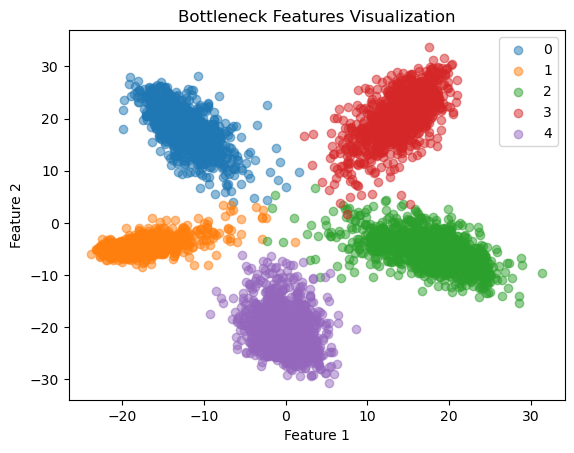

In [41]:
# Instantiate the model and switch it to evaluation mode
model.eval()

# Assuming the test loader is already created and named 'test_loader'
# Collect the bottleneck features and labels
features = []
labels = []
with torch.no_grad():  # No need to track gradients for visualization
    for data, target in wrapper.test_loader:
        bottleneck_features = model(data, return_feature=True)
        features.append(bottleneck_features.cpu().numpy())
        labels.append(target.cpu().numpy())

# Concatenate all features and labels
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# Plot the features in 2D space
for i in range(5):  # Assuming 5 classes 
    idxs = labels == i
    plt.scatter(features[idxs, 0], features[idxs, 1], label=str(i), alpha=0.5)

plt.legend()
plt.title('Bottleneck Features Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

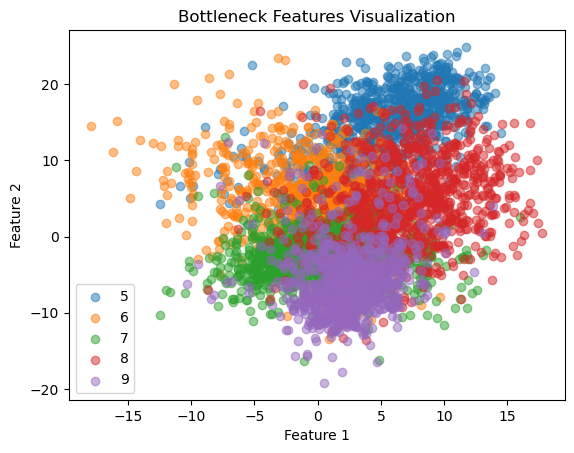

In [44]:
# Instantiate the model and switch it to evaluation mode
model.eval()
wrapper.update_phase('finetune')

# Assuming the test loader is already created and named 'test_loader'
# Collect the bottleneck features and labels
features = []
labels = []
with torch.no_grad():  # No need to track gradients for visualization
    for data, target in wrapper.test_loader:
        bottleneck_features = model(data, return_feature=True)
        features.append(bottleneck_features.cpu().numpy())
        labels.append(target.cpu().numpy())

# Concatenate all features and labels
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# Plot the features in 2D space
for i in range(5):  # Assuming 5 classes 
    idxs = labels == i
    plt.scatter(features[idxs, 0], features[idxs, 1], label=str(i+5), alpha=0.5)

plt.legend()
plt.title('Bottleneck Features Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

### Compare to Baseline End-to-end Models
Skip this one for now

In [111]:
params["lr"] = 0.001
dataloader_wrapped.update_phase('finetune')

baseline_results = []

for sampled_percentage in percentages:
    # Create DNN model
    baseline_model = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
                        hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=params['use_pooling'])
    baseline_model.to(device)

    # Reduce the dataset
    train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed=random.randint(0, 100))
    dataset_namespace_new = SimpleNamespace(train_loader=train_loader_reduced, test_loader=dataloader_wrapped.test_loader, val_loader=dataloader_wrapped.val_loader)

    # Train and evaluate
    trainer = Trainer(baseline_model, dataset_namespace_new, params)
    train_acc, test_acc, effective_epochs, checkpoints = trainer.train(verbose=0)
    print(f"Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

    # Store the results
    baseline_results.append((sampled_percentage, repeat, train_acc, test_acc))

print(baseline_results)

# first of all convert results to df and calculate the mean and std of repats
repeats_mean = []
i = 0
for sampled_percentage in percentages:
    train, test = [], []
    for repeat in range(repeats):
        train.append(results[i][3])
        test.append(results[i][4])
        i += 1
    repeats_mean.append((sampled_percentage, np.mean(train), np.std(train), np.mean(test), np.std(test)))
df_baseline = pd.DataFrame(results, columns=['Percentage', 'Mean Train Accuracy', 'Std Train Accuracy', 'Mean Test Accuracy', 'Std Test Accuracy'])
df_baseline

KeyboardInterrupt: ignored